In [1]:
import cv2 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow

2025-08-01 10:19:51.094083: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-01 10:19:51.177786: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-01 10:19:51.177817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-01 10:19:51.193556: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-01 10:19:51.223932: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#Carregamento base de dados
data = pd.read_csv('Material/fer2013/fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


Text(0.5, 1.0, 'Imagens x emoções')

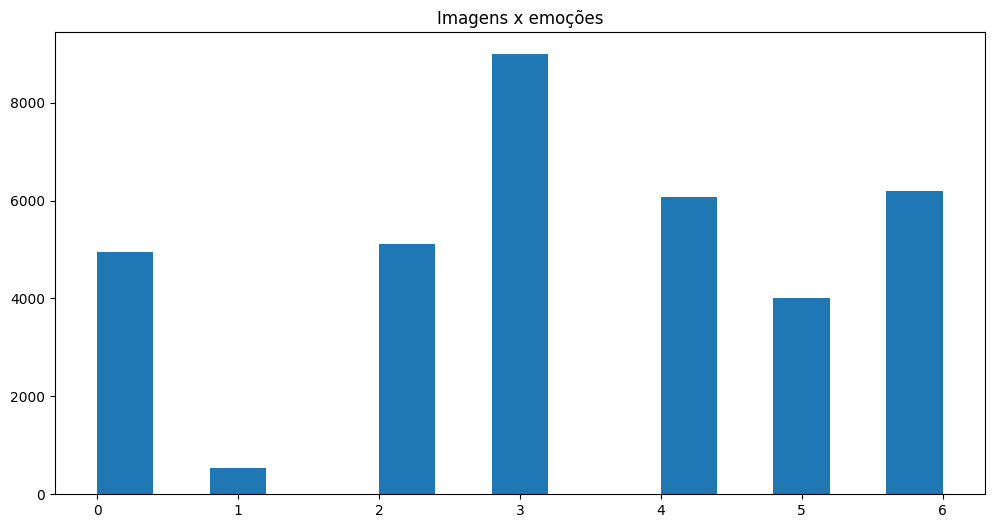

In [3]:
#Historgrama da quantidade de imagens por emoção
plt.figure(figsize=(12,6))
plt.hist(data['emotion'], bins = 15)
plt.title("Imagens x emoções")

In [4]:
#Começo do preprocessamento, passando os pixels para uma lista
pixels = data['pixels'].tolist()

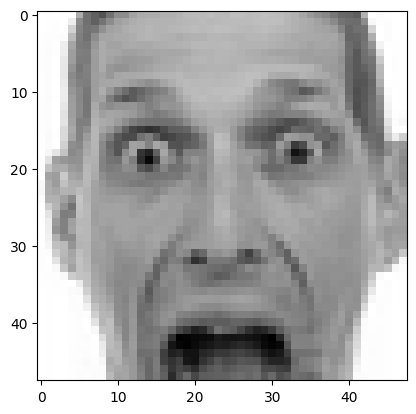

In [5]:
#Transformando os pixels de str para array np
largura, altura = 48,48
faces = []
amostras = 0
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')]
    face = np.asarray(face).reshape(largura, altura)
    faces.append(face)

    if(amostras < 10):
        plt.imshow(face, cmap='gray')
    amostras += 1

In [6]:
print("Numero total de imagens no dataset: ", str(len(faces)))

Numero total de imagens no dataset:  35887


In [7]:
faces = np.asarray(faces)

In [8]:
faces.shape

(35887, 48, 48)

In [9]:
faces = np.expand_dims(faces, -1)
faces.shape

(35887, 48, 48, 1)

In [10]:
def normalizar(x):
    x = x.astype('float32')
    x = x / 255.0
    return x
faces = normalizar(faces)
faces[0]

array([[[0.27450982],
        [0.3137255 ],
        [0.32156864],
        ...,
        [0.20392157],
        [0.16862746],
        [0.16078432]],

       [[0.25490198],
        [0.23921569],
        [0.22745098],
        ...,
        [0.21960784],
        [0.20392157],
        [0.17254902]],

       [[0.19607843],
        [0.16862746],
        [0.21176471],
        ...,
        [0.19215687],
        [0.21960784],
        [0.18431373]],

       ...,

       [[0.35686275],
        [0.25490198],
        [0.16470589],
        ...,
        [0.28235295],
        [0.21960784],
        [0.16862746]],

       [[0.3019608 ],
        [0.32156864],
        [0.30980393],
        ...,
        [0.4117647 ],
        [0.27450982],
        [0.18039216]],

       [[0.3019608 ],
        [0.28235295],
        [0.32941177],
        ...,
        [0.41568628],
        [0.42745098],
        [0.32156864]]], dtype=float32)

In [11]:
emocoes  = pd.get_dummies(data['emotion'], dtype='int').values

In [12]:
emocoes[0]

array([1, 0, 0, 0, 0, 0, 0])

Pré processamento dos dados concluidos, agora importar as bibliotecas necessárias para criação do modelo

In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

Base de dados, com 90% para treinos e 10% para testes

In [14]:
X_train, X_test, y_train, y_test = train_test_split(faces,emocoes, test_size = 0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 41)

In [15]:
print('Numero de imagens no conjunto de treinamento', len(X_train))
print('Numero de imagens no conjunto de teste', len(X_test))
print('Numero de imagens no conjunto de validação', len(X_val))

Numero de imagens no conjunto de treinamento 29068
Numero de imagens no conjunto de teste 3589
Numero de imagens no conjunto de validação 3230


In [16]:
np.save('mod_xtest', X_test)
np.save('mod_ytest', y_test)

In [17]:
num_features = 64
num_labels = 7
batch_size = 64 
epochs = 10
widht, height = 48,48

model = Sequential()

model.add(Conv2D(num_features, kernel_size = (3,3), activation ='relu',
                input_shape=(widht,height,1), data_format = 'channels_last',
                kernel_regularizer= l2(0.01))) #Primeira camada de convolução

model.add(Conv2D(num_features, kernel_size = (3,3), activation ='relu', padding='same')) #Segunda
model.add(BatchNormalization()) 
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) #Pooling
model.add(Dropout(0.5)) #Evitar overffiting

model.add(Conv2D(2*num_features, kernel_size = (3,3), activation ='relu', padding='same')) 
model.add(BatchNormalization()) 
model.add(Conv2D(2*num_features, kernel_size = (3,3), activation ='relu', padding='same')) 
model.add(BatchNormalization()) 
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size = (3,3), activation ='relu', padding='same')) 
model.add(BatchNormalization()) 
model.add(Conv2D(2*2*num_features, kernel_size = (3,3), activation ='relu', padding='same')) 
model.add(BatchNormalization()) 
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size = (3,3), activation ='relu', padding='same')) 
model.add(BatchNormalization()) 
model.add(Conv2D(2*2*2*num_features, kernel_size = (3,3), activation ='relu', padding='same')) 
model.add(BatchNormalization()) 
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.5))

model.add(Flatten()) #Transformar a matriz em um vetor

#Camada densa
model.add(Dense(2*2*2*num_features, activation='relu')) #Primeira camada oculta
model.add(Dropout(0.4)) #Evita overffiting
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4)) 
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5)) 

model.add(Dense(num_labels, activation='softmax'))

model.summary()


2025-08-01 10:20:03.398807: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-01 10:20:03.600162: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-01 10:20:03.604764: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization (Batch  (None, 46, 46, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 128)       7

In [18]:
model.compile(loss = 'categorical_crossentropy',
             optimizer = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-7),
             metrics=['accuracy']) #COmpilar o modelo

arquivo_modelo = 'modelo_01_expressoes.h5' #Salvar os pesos do modelo
arquivo_modelo_json = 'modelo_01_expressoes_json' #Salvar a arquitetura do modelo

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor = 0.9, patience=3, verbose = 1) #maneira de evitar o plato
early_stopper = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 8, verbose = 1, mode = 'auto') #Se a rede não melhorar durante 8 epocas ele para o treinamento
checkpointer = ModelCheckpoint(arquivo_modelo, monitor='val_loss', verbose = 1, save_best_only=True) #Salva o modelo com os melhores pesos

In [19]:
model_json = model.to_json() #Salvar o modelo em json
with open(arquivo_modelo_json, 'w') as json_file:
    json_file.write(model_json)

In [20]:
history = model.fit(np.array(X_train), np.array(y_train),
                   batch_size = batch_size,
                   epochs = 10,
                   verbose = 1,
                   validation_data = (np.array(X_val), np.array(y_val)), 
                   shuffle = True,
                   callbacks=[lr_reducer, early_stopper, checkpointer])

Epoch 1/10


2025-08-01 10:20:05.695810: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-08-01 10:20:05.957823: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-08-01 10:20:07.615086: I external/local_xla/xla/service/service.cc:168] XLA service 0x7345cd0e16e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-01 10:20:07.615111: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-08-01 10:20:07.630090: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754054407.728535    7792 device_compiler.h:186] Compiled c

455/455 [==============================] - ETA: 0s - loss: 1.9857 - accuracy: 0.2153
Epoch 1: val_loss improved from inf to 1.83217, saving model to modelo_01_expressoes.h5
455/455 [==============================] - 42s 74ms/step - loss: 1.9857 - accuracy: 0.2153 - val_loss: 1.8322 - val_accuracy: 0.2594 - lr: 0.0010
Epoch 2/10


/home/lucas/anaconda3/envs/tf_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


454/455 [============================>.] - ETA: 0s - loss: 1.8352 - accuracy: 0.2487
Epoch 2: val_loss improved from 1.83217 to 1.81298, saving model to modelo_01_expressoes.h5
455/455 [==============================] - 29s 64ms/step - loss: 1.8353 - accuracy: 0.2487 - val_loss: 1.8130 - val_accuracy: 0.2594 - lr: 0.0010
Epoch 3/10
454/455 [============================>.] - ETA: 0s - loss: 1.8215 - accuracy: 0.2498
Epoch 3: val_loss improved from 1.81298 to 1.78135, saving model to modelo_01_expressoes.h5
455/455 [==============================] - 29s 64ms/step - loss: 1.8214 - accuracy: 0.2498 - val_loss: 1.7813 - val_accuracy: 0.2594 - lr: 0.0010
Epoch 4/10
454/455 [============================>.] - ETA: 0s - loss: 1.8048 - accuracy: 0.2518
Epoch 4: val_loss improved from 1.78135 to 1.77724, saving model to modelo_01_expressoes.h5
455/455 [==============================] - 29s 64ms/step - loss: 1.8048 - accuracy: 0.2519 - val_loss: 1.7772 - val_accuracy: 0.2777 - lr: 0.0010
Epoch 5/1

In [21]:
print(history.history)

{'loss': [1.9856723546981812, 1.8352512121200562, 1.8214157819747925, 1.8048205375671387, 1.7160234451293945, 1.5916494131088257, 1.5055066347122192, 1.4554487466812134, 1.4051622152328491, 1.366165280342102], 'accuracy': [0.21525388956069946, 0.24869272112846375, 0.24982799589633942, 0.251857727766037, 0.3082427382469177, 0.36490297317504883, 0.40498143434524536, 0.4268955588340759, 0.4587174952030182, 0.4772946238517761], 'val_loss': [1.8321672677993774, 1.8129849433898926, 1.7813469171524048, 1.7772399187088013, 1.9768856763839722, 1.4585667848587036, 1.4742488861083984, 1.3489694595336914, 1.3353289365768433, 1.2421948909759521], 'val_accuracy': [0.2594427168369293, 0.2594427168369293, 0.2594427168369293, 0.2777089774608612, 0.27956655621528625, 0.4095975160598755, 0.43065014481544495, 0.47275543212890625, 0.49938079714775085, 0.5260061621665955], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]}


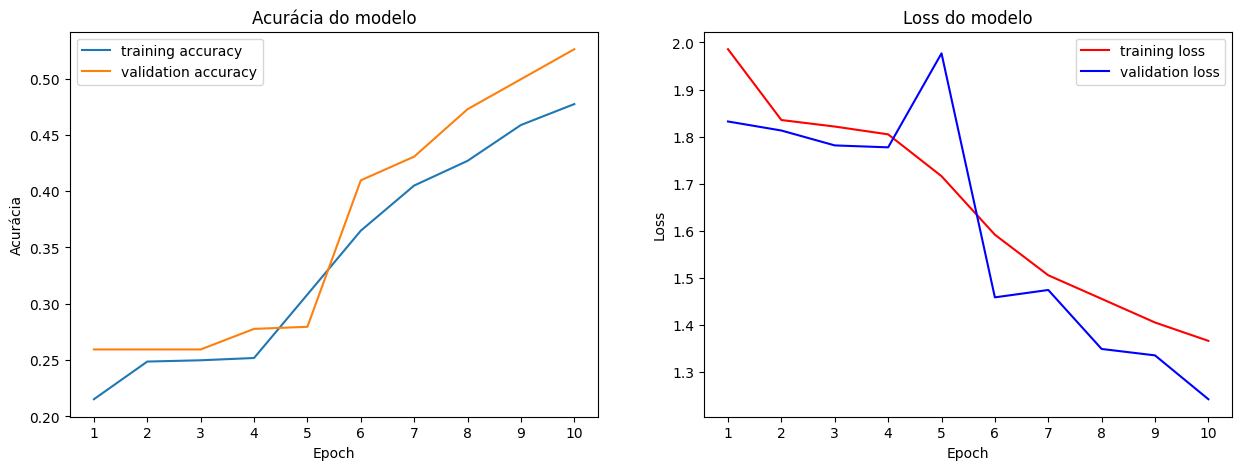

In [22]:
def plota_historico_modelo(historico_modelo):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1, len(historico_modelo.history['accuracy']) + 1), historico_modelo.history['accuracy'])
    axs[0].plot(range(1, len(historico_modelo.history['val_accuracy']) + 1), historico_modelo.history['val_accuracy'])
    axs[0].set_title('Acurácia do modelo')
    axs[0].set_ylabel('Acurácia')
    axs[0].set_xlabel('Epoch')
   
    step = max(1, len(historico_modelo.history['accuracy']) // 10) 
    axs[0].set_xticks(np.arange(1, len(historico_modelo.history['accuracy']) + 1, step))
    axs[0].legend(['training accuracy', 'validation accuracy'], loc = 'best')
    
    
    axs[1].plot(range(1, len(historico_modelo.history['loss']) + 1), historico_modelo.history['loss'], 'r')
    axs[1].plot(range(1, len(historico_modelo.history['val_loss']) + 1), historico_modelo.history['val_loss'], 'b')
    axs[1].set_title('Loss do modelo')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
   
    step = max(1, len(historico_modelo.history['loss']) // 10) # Calcula o passo (mínimo de 1)
    axs[1].set_xticks(np.arange(1, len(historico_modelo.history['loss']) + 1, step))
    axs[1].legend(['training loss', 'validation loss'], loc = 'best')
plota_historico_modelo(history)

In [23]:
scores = model.evaluate(np.array(X_test), np.array(y_test), batch_size = batch_size)

57/57 [==============================] - 1s 26ms/step - loss: 1.2723 - accuracy: 0.5202


In [24]:
scores
print("Acuracia", scores[0])
print("Loss", scores[1])

Acuracia 1.2722742557525635
Loss 0.5202006101608276


In [25]:
#Dados carregados para serem utilizados na matriz de confusão
true_y = []
pred_y = []
x = np.load('mod_xtest.npy')
y = np.load('mod_ytest.npy')

In [27]:
#X representa os pixels da primeira imagem, e y a emoção
print(x[0])
print(y[0])

[[[0.5568628 ]
  [0.5803922 ]
  [0.59607846]
  ...
  [0.3529412 ]
  [0.3529412 ]
  [0.3647059 ]]

 [[0.5568628 ]
  [0.5764706 ]
  [0.5921569 ]
  ...
  [0.33333334]
  [0.36078432]
  [0.40392157]]

 [[0.5529412 ]
  [0.5686275 ]
  [0.5921569 ]
  ...
  [0.3372549 ]
  [0.32156864]
  [0.37254903]]

 ...

 [[0.0627451 ]
  [0.08235294]
  [0.07058824]
  ...
  [0.08235294]
  [0.09019608]
  [0.11372549]]

 [[0.05490196]
  [0.0627451 ]
  [0.05490196]
  ...
  [0.07450981]
  [0.07843138]
  [0.09803922]]

 [[0.04705882]
  [0.04705882]
  [0.04705882]
  ...
  [0.06666667]
  [0.07450981]
  [0.09411765]]]
[0 0 0 1 0 0 0]


In [32]:
#Carregando a estrutura da rede neural criada
json_file = open(arquivo_modelo_json,'r')
loaded_model_json = json_file.read()
json_file.close()

In [33]:
#Carregando os melhores pesos dentro do treinamento
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(arquivo_modelo)

In [35]:
y_pred = loaded_model.predict(x)

113/113 [==============================] - 2s 9ms/step


In [37]:
y_pred[0]

array([0.03962476, 0.00258266, 0.02422595, 0.75843847, 0.05988166,
       0.02086169, 0.09438471], dtype=float32)

In [60]:
yp = y_pred.tolist()
yt = y.tolist()
count = 0

In [61]:
for i in range(len(y)):
    yy = max(yp[i])
    yyt = max(yt[i])
    pred_y.append(yp[i].index(yy))
    true_y.append(yt[i].index(yyt))
    if (yp[i].index(yy) == yt[i].index(yyt)):
        count += 1

acc = (count / len(y)) * 100

In [62]:
print('Acuracia no conjunto de testes: ' + str(acc))

Acuracia no conjunto de testes: 52.02006129841181


In [63]:
np.save('truey_mod01', true_y)
np.save('pred_mod01', pred_y)

In [64]:
from sklearn.metrics import confusion_matrix

In [65]:
y_true = np.load('truey_mod01.npy')
y_pred = np.load('pred_mod01.npy')

In [67]:
cm = confusion_matrix(y_true, y_pred)
expressoes = ['Raiva', 'Nojo', 'Medo', 'Feliz', 'Triste', 'Surpreso', 'Neutro']
titulo = 'Matriz de confusão'
print(cm)

[[1694    0  110  594 1727  132 1221]
 [ 220    0   11  110  176    0   55]
 [ 737    0  330  891 1639  792 1606]
 [ 132    0   22 8481  539   88  429]
 [ 561    0   77  682 2816   77 2255]
 [ 165    0  264  704  143 2860  418]
 [ 154    0   44  781 1353   33 4356]]


Configuação utilizando o matplot lib para demonstrar visualmente melhor sobre a matriz de confusão

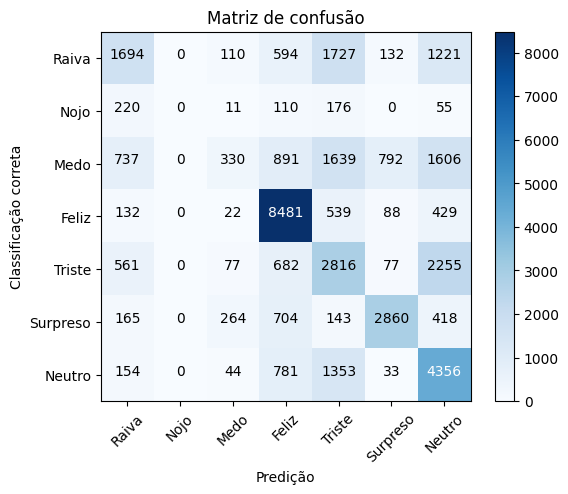

In [82]:
import itertools
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(titulo)
plt.colorbar()
tick_marks = np.arange(len(expressoes))
plt.xticks(tick_marks, expressoes, rotation=45)
plt.yticks(tick_marks, expressoes);
fmt = 'd'
thresh = cm.max() / 2
for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i,j], fmt), horizontalalignment='center', color='white' if cm[i,j] > thresh else 'black')
plt.ylabel('Classificação correta')
plt.xlabel('Predição')
plt.savefig('matriz_confusao_mod01.png')

(-0.5, 753.5, 394.5, -0.5)

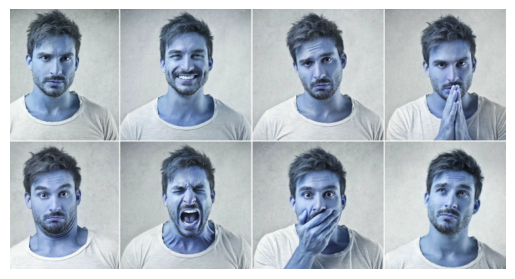

In [85]:
imagem = cv2.imread('Material/testes/teste02.jpg')
plt.imshow(imagem)
plt.axis('off')

(-0.5, 753.5, 394.5, -0.5)

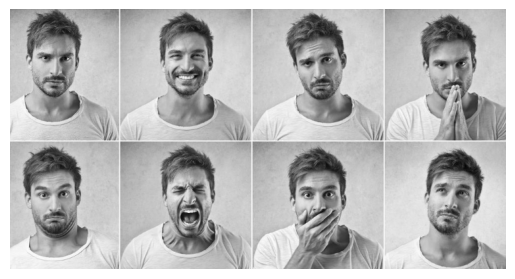

In [97]:
original = imagem.copy()
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.axis('off')

In [98]:
face_cascade = cv2.CascadeClassifier('Material/haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, 1.1, 3)


In [92]:
faces

array([[625,  49,  91,  91],
       [224,  35,  90,  90],
       [ 23,  41,  92,  92],
       [420,  43,  97,  97],
       [420, 242,  97,  97],
       [ 18, 243,  98,  98],
       [229, 242,  85,  85],
       [627, 241,  91,  91]], dtype=int32)

1/1 [==============================] - 0s 17ms/step


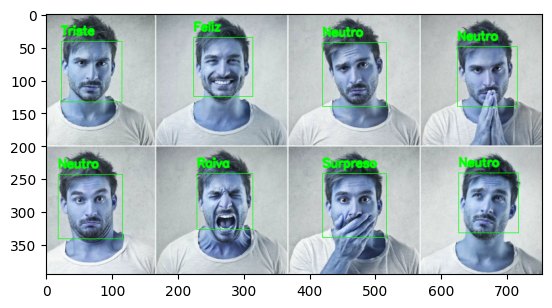

In [99]:
for(x, y, w, h) in faces:
    cv2.rectangle(original, (x, y), (x + w, y + h), (0,255,0), 1)
    roi_gray = gray[y:y + h, x:x + w]
    roi_gray = roi_gray.astype('float') / 255.0
    cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48,48)), -1), 0)
    prediction = loaded_model.predict(cropped_img)[0]
    cv2.putText(original, expressoes[int(np.argmax(prediction))], (x, y -10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)
plt.imshow(original)